# Курсовой проект

Укладников Андрей


### Постановка задачи<a class="anchor" id="course_project_task"></a>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
AUkladnikov_predictions.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1($\beta$ = 1) > 0.5 при Precision > 0.5 и Recall > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)


# *Построение модели классификации*

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые льготы
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [1]:
from sklearn.model_selection import train_test_split 
import numpy as np
import pandas as pd
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

**Пути к директориям и файлам**

In [2]:
TRAIN_DATASET_PATH = 'data/course_project_train.csv'
TEST_DATASET_PATH = 'data/course_project_test.csv'

**Загрузка данных**

In [3]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [4]:
df_train.shape

(7500, 17)

In [5]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [6]:
df_test.shape

(2500, 16)

### 1. Приведение типов<a class="anchor" id="cast"></a>

In [7]:
for colname in ['Home Ownership', 'Years in current job', 'Purpose', 'Term']:
    df_train[colname] = df_train[colname].astype(str)
    
for colname in ['Home Ownership', 'Years in current job', 'Purpose', 'Term']:
    df_test[colname] = df_test[colname].astype(str)

In [8]:
df_train.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [9]:
df_test.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
dtype: object

### 2. Обзор обучающего датасета<a class="anchor" id="cast"></a>

**Обзор целевой переменной**

In [10]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

**Обзор количественных признаков**

In [11]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


**Обзор номинативных/категориальных признаков**

In [12]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
nan           371
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses 

### 3. Обработка пропусков<a class="anchor" id="gaps"></a>

In [13]:
len(df_train) - df_train.count()

Home Ownership                     0
Annual Income                   1557
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [14]:
df_train.loc[df_train['Annual Income'].isnull() , 'Annual Income'] = df_train['Annual Income'].mean()
df_train.loc[df_train['Months since last delinquent'].isnull() , 'Months since last delinquent'] = df_train['Months since last delinquent'].mean()
df_train.loc[df_train['Bankruptcies'].isnull() , 'Bankruptcies'] = df_train['Bankruptcies'].mean()
df_train.loc[df_train['Credit Score'].isnull() , 'Credit Score'] = df_train['Credit Score'].mean()

In [15]:
len(df_train) - df_train.count()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

### 4. Обработка выбросов<a class="anchor" id="outliers"></a>

In [16]:
df_train.loc[df_train['Years in current job']=='nan' , 'Years in current job'] = df_train['Years in current job'].mode()[0]


### 5. Построение новых признаков<a class="anchor" id="new_features"></a>

**Id**

In [17]:
df_train['ID'] = df_train.index.tolist()

**Выделение целевой переменной и групп признаков**

In [18]:
TARGET_NAME = 'Credit Default'


### Анализ целевой переменной<a class="anchor" id="target_analysis"></a>

In [19]:
df_train[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

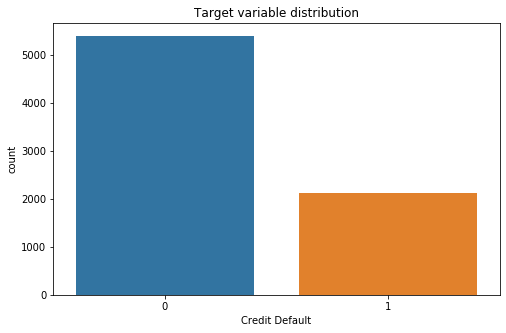

In [20]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df_train)

plt.title('Target variable distribution')
plt.show()

### 6. Отбор признаков<a class="anchor" id="new_features"></a>

**Оценка признака "Home Ownership" в разрезе целевой переменной**

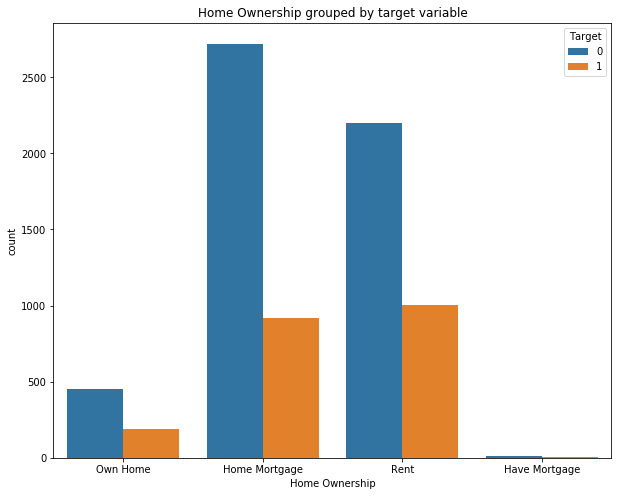

In [21]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Home Ownership", hue=TARGET_NAME, data=df_train)
plt.title('Home Ownership grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

**Наблюдение**

Изучив получившийся график, видно, что значения Home Mortage и Rent признака Home Ownership имеют схожие доли в разрезе целевой переменной. Если это действительно так, то можно будет, например, объединить их в одну категорию.

**Гипотеза** 

* Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
* Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
* Критерий: Хи-квадрат Пирсона
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Для проверки данной гипотезы необходимо подать наблюдаемые частоты категорий Home Mortage и Rent признака Home Ownership в выбранный критерий, после чего оценить значение достигаемого уровня значимости p-value и сравнить с его с выбранным порогом альфа, если p-value получится больше выбранного порога, то гипотезу о согласованности частот можно не отбрасывать.

*Сформируем выборку и рассчитаем наблюдаемые частоты*

In [22]:
Home_Ownership_and_target_s = df_train.loc[df_train['Home Ownership'].isin(['Home Mortgage', 'Rent']), ['ID', 'Home Ownership', TARGET_NAME]].sample(3000)
table = Home_Ownership_and_target_s.pivot_table(values='ID', index='Home Ownership', columns=TARGET_NAME, aggfunc='count')
table

Credit Default,0,1
Home Ownership,,
Home Mortgage,1196,404
Rent,954,446


*Проверим нашу гипотезу используя критерий Хи-квадрат Пирсона*

In [23]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

6.161431509679033e-05

In [24]:
alpha=0.05
p < alpha

True

P-value получилось меньше выбранного уровня значимости, соответственно мы отвергаем нулевую гипотезу и отсюда следует, что категории Home Mortgage и Rent по разному влияют на целевую переменную и их нельзя объединить в одну категорию. 

**Оценка признака "Years in current job" в разрезе целевой переменной**

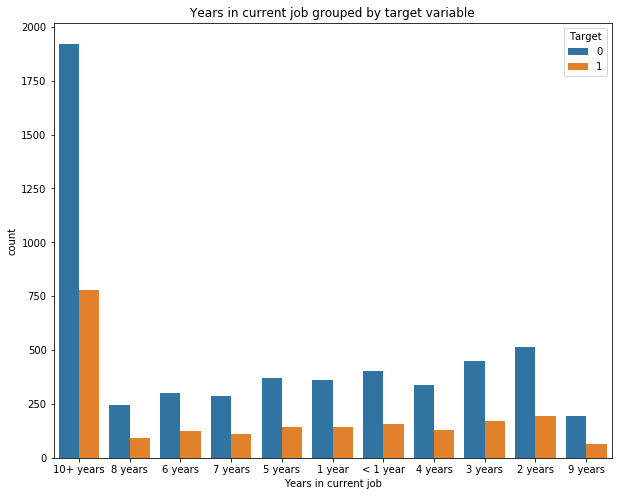

In [25]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Years in current job", hue=TARGET_NAME, data=df_train)
plt.title('Years in current job grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

**Наблюдение**

Изучив получившийся график, видно, что значения  5 years , 1 years и <1years признака Years in current job имеют схожие доли в разрезе целевой переменной. Если это действительно так, то можно будет, например, объединить их в одну категорию.

**Гипотеза** 

* Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
* Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
* Критерий: Хи-квадрат Пирсона
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Для проверки данной гипотезы необходимо подать наблюдаемые частоты категорий  5 years , 1 years и <1years признака Years in current job в выбранный критерий, после чего оценить значение достигаемого уровня значимости p-value и сравнить с его с выбранным порогом альфа, если p-value получится больше выбранного порога, то гипотезу о согласованности частот можно не отбрасывать.

*Сформируем выборку и рассчитаем наблюдаемые частоты*

In [26]:
Years_in_current_job_and_target_s = df_train.loc[df_train['Years in current job'].isin(['< 1 year', '1 year','5 years']), ['ID', 'Years in current job', TARGET_NAME]].sample(1000)
table = Years_in_current_job_and_target_s.pivot_table(values='ID', index='Years in current job', columns=TARGET_NAME, aggfunc='count')
table

Credit Default,0,1
Years in current job,,
1 year,229,98
5 years,227,103
< 1 year,247,96


In [27]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

0.6524438961377901

In [28]:
alpha=0.05
p < alpha

False

P-value получилось больше выбранного уровня значимости, соответственно у нас нет оснований для отвержения нулевой гипотезы и можно допустить, что категории 5 years , 1 years и <1years признака Years in current job одинаково влияют на целевую переменную и их можно объединить в одну категорию, например . 

In [29]:
df_train.loc[df_train['Years in current job'].isin(['< 1 year', '1 year','5 years']),['Years in current job']]='less_1_and_1_and_5_year'

**Оценка признака "Purpose" в разрезе целевой переменной**

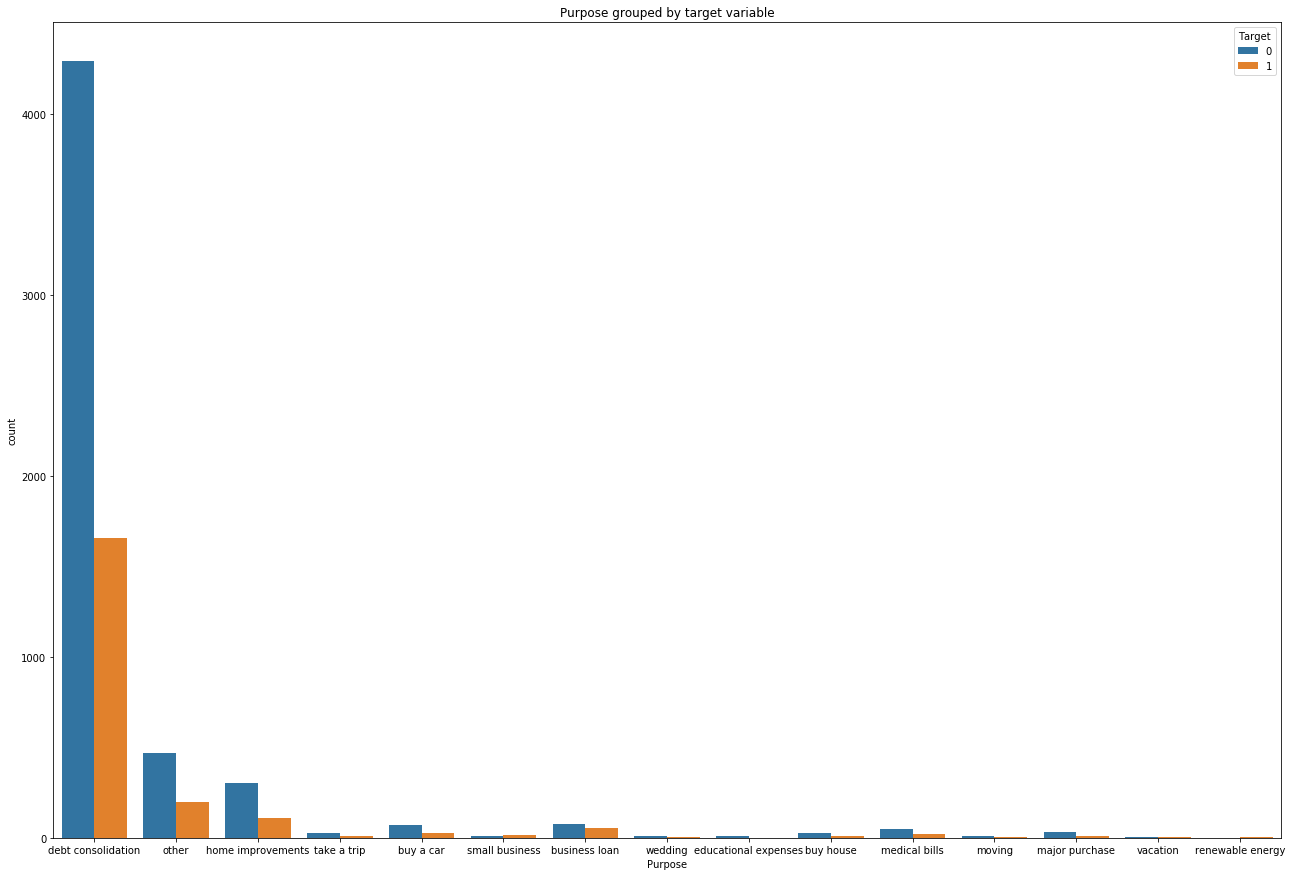

In [30]:
plt.figure(figsize=(22, 15))

sns.countplot(x="Purpose", hue=TARGET_NAME, data=df_train)
plt.title('Purpose grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

**Наблюдение**

Изучив получившийся график, видно, что значения  other, home improvements 
признака Purpose имеют схожие доли в разрезе целевой переменной. Если это действительно так, то можно будет, например, объединить их в одну категорию.

**Гипотеза** 

* Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
* Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
* Критерий: Хи-квадрат Пирсона
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Для проверки данной гипотезы необходимо подать наблюдаемые частоты категорий  other, home improvements признака Purpose в выбранный критерий, после чего оценить значение достигаемого уровня значимости p-value и сравнить с его с выбранным порогом альфа, если p-value получится больше выбранного порога, то гипотезу о согласованности частот можно не отбрасывать.


*Сформируем выборку и рассчитаем наблюдаемые частоты*

In [31]:
Purpose_and_target_s = df_train.loc[df_train['Purpose'].isin(['other', 'home improvements']), ['ID', 'Purpose', TARGET_NAME]].sample(1000)
table = Purpose_and_target_s.pivot_table(values='ID', index='Purpose', columns=TARGET_NAME, aggfunc='count')
table

Credit Default,0,1
Purpose,,
home improvements,284,100
other,433,183


In [32]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

0.2106684281963325

In [33]:
alpha=0.05
p < alpha

False

P-value получилось больше выбранного уровня значимости, соответственно у нас нет оснований для отвержения нулевой гипотезы и можно допустить, что категории other, home improvements признака Purpose одинаково влияют на целевую переменную и их можно объединить в одну категорию, например,other and home improvements . 

In [34]:
df_train.loc[df_train['Purpose'].isin(['other', 'home improvements']),['Purpose']]='other and home improvements'

Остальные категории кроме debt consolidation, other, home improvements   практически не влияют на целевую переменную и их можно объединить в 1  переменную.

In [35]:
df_train.loc[df_train['Purpose'].isin(['business loan', 'buy a car', 'medical bills', 'major purchase', 'take a trip', 'buy house', 'small business', 'wedding', 'moving', 'educational expenses', 'vacation', 'renewable energy']), ['Purpose']]='small purposes'

**Оценка признака "Term" в разрезе целевой переменной**

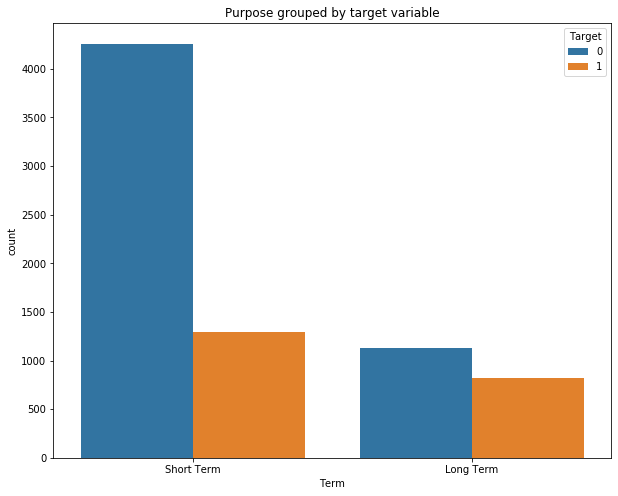

In [36]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Term", hue=TARGET_NAME, data=df_train)
plt.title('Purpose grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

Видно, что эти 2 категории по разному влияют на целевую переменную

In [37]:
#for cat_colname in df_train.select_dtypes(include='object').columns:
#    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

**Dummies**

In [38]:
df_prep_train=df_train
for cat_colname in df_prep_train.select_dtypes(include='object').columns[0:]:
    df_prep_train = pd.concat([df_prep_train, pd.get_dummies(df_prep_train[cat_colname], prefix=cat_colname)], axis=1)

In [39]:
df_train.shape

(7500, 18)

In [40]:
df_prep_train.shape

(7500, 36)

In [41]:
df_prep_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Years in current job_6 years,Years in current job_7 years,Years in current job_8 years,Years in current job_9 years,Years in current job_less_1_and_1_and_5_year,Purpose_debt consolidation,Purpose_other and home improvements,Purpose_small purposes,Term_Long Term,Term_Short Term
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,34.6926,1.0,...,0,0,0,0,0,1,0,0,0,1
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,34.6926,0.0,...,0,0,0,0,0,1,0,0,1,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,34.6926,0.0,...,0,0,1,0,0,1,0,0,0,1
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,34.6926,1.0,...,1,0,0,0,0,1,0,0,0,1
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,34.6926,0.0,...,0,0,1,0,0,1,0,0,0,1


In [42]:
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df_prep_train.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()

In [43]:
print(BASE_FEATURE_NAMES)
print('******************************')
print(NEW_FEATURE_NAMES)

['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'ID']
******************************
['Home Ownership_Have Mortgage', 'Home Ownership_Home Mortgage', 'Home Ownership_Own Home', 'Home Ownership_Rent', 'Years in current job_10+ years', 'Years in current job_2 years', 'Years in current job_3 years', 'Years in current job_4 years', 'Years in current job_6 years', 'Years in current job_7 years', 'Years in current job_8 years', 'Years in current job_9 years', 'Years in current job_less_1_and_1_and_5_year', 'Purpose_debt consolidation', 'Purpose_other and home improvements', 'Purpose_small purposes', 'Term_Long Term', 'Term_Short Term']


**Проверка признаков для определения тех признаков, которые не информативны и их можно отбросить**

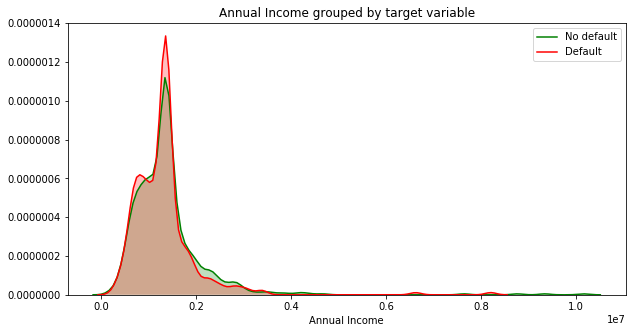

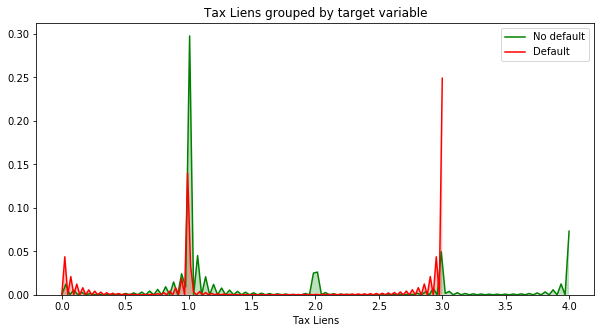

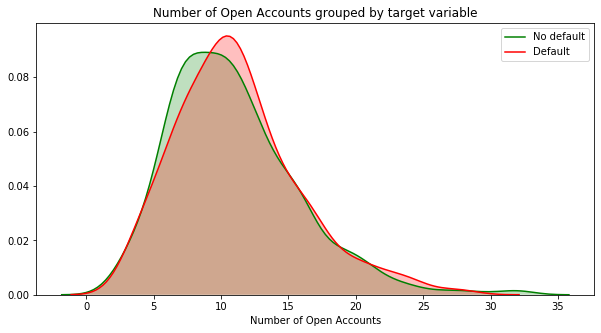

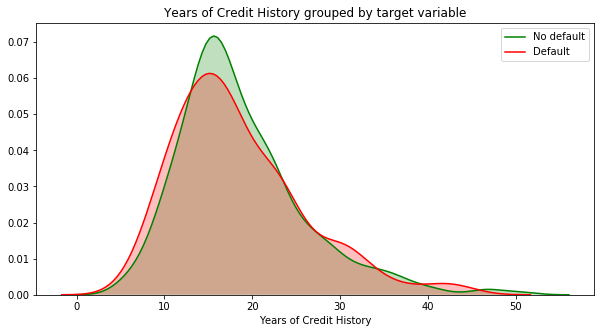

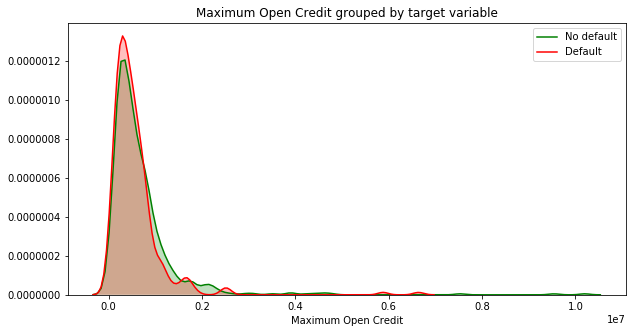

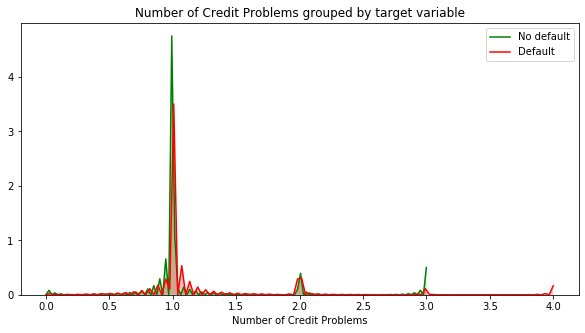

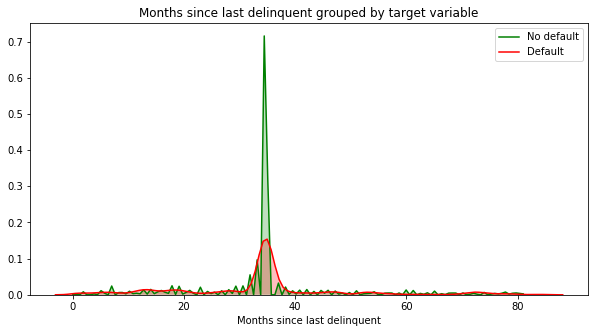

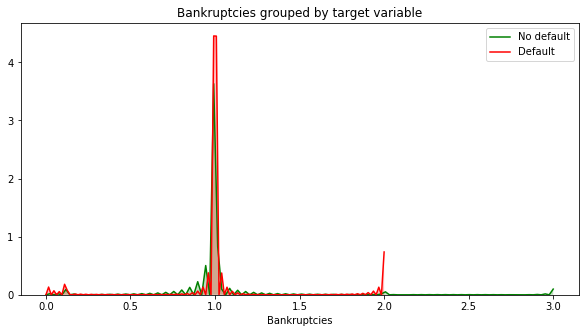

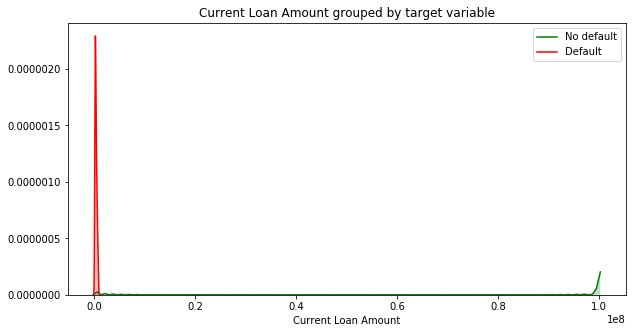

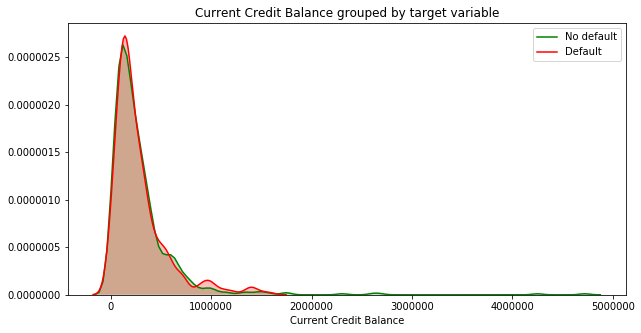

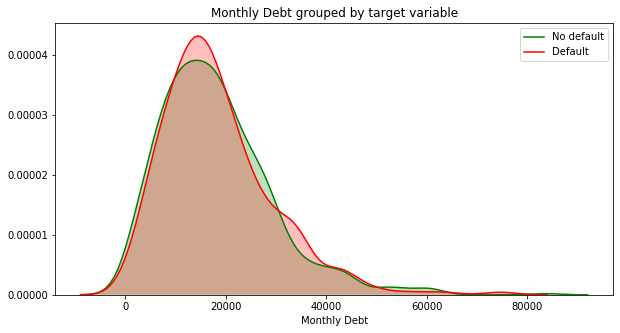

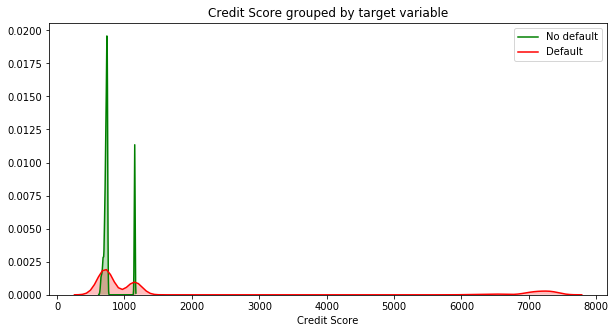

In [44]:
features_s = {}
features_target_0={}
features_target_1={}
features_with_target_s={}
for feature in ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History','Maximum Open Credit','Number of Credit Problems','Months since last delinquent','Bankruptcies','Current Loan Amount','Current Credit Balance','Monthly Debt','Credit Score']:
    
    feature_with_target_s = df_prep_train[[feature, TARGET_NAME]].sample(1000)
    feature_s = feature_with_target_s[feature]
    feature_target_0 = feature_s[feature_with_target_s[TARGET_NAME] == 0]
    feature_target_1 = feature_s[feature_with_target_s[TARGET_NAME] == 1]

    plt.figure(figsize=(10, 5))

    sns.kdeplot(feature_target_0, shade=True, label='No default', color='g')
    sns.kdeplot(feature_target_1, shade=True, label='Default', color='r')

    plt.xlabel(feature)
    plt.title(feature + ' grouped by target variable')
    plt.show()
    features_s[feature]=feature_s
    features_target_0[feature]=feature_target_0
    features_target_1[feature]=feature_target_1
    features_with_target_s[feature]=feature_with_target_s
    
    

Исследуем следующие некотегариальные признаки которые вероятно имеют сходное распределение по целевой переменной, близкое к нормальному и поэтому между этими признаками и целевой переменной, возможно функциональная зависимость несущественна и ей можно пренебречь. В таком случае эти признаки можно отбросить.Проверим эти признаки на "нормальность" с помощью критерия Шапиро-Уилка и далее если надо, исследуем их с помощью критерия Манна-Уитни и доверительных интервалов.
Также признаки, которые явно не имеют нормального распределения, исследуем с только помощью критерия Манна-Уитни и доверительных интервалов.


**Оценка признака "Annual Income" в разрезе целевой переменной**

**Наблюдение**

Похоже что две группы, полученные в результате разбиения признака "Annual Income" по целевой переменной, имеют различные распределения, что может помочь при построение модели, т.к. это будет означать, что между признаком "Annual Income" и целевой переменной, возможно, существует некоторая функциональная зависимость.

**Гипотеза** 
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента (t-тест) и его аналоги
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Что бы проверить данную гипотезу сравним две выборки из рассматриваемых групп на предмет равенства средних значений.
Если вероятность того, что мат. ожидания в исходных группах равны, при данных выборках, буде менее 5%, то можно будет говорить о том, что скорее всего выборки имеют различные распределения.

Для следующих исследуемых признаков будем выдвигать такую же гипотезу, но для текущего рассматриваемого признака, поэтому далее гипотеза будет формироваться только в виде обозначений.

*Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка признака 'Annual Income'*

$H0: Annual Income \sim N(\mu, \sigma^2)$  
$H1: H0  не  верна$

In [45]:
stat, p_value = shapiro(features_s['Annual Income'])
p_value

7.317440450857762e-41

In [46]:
alpha=0.05
p_value < alpha

True

По полученному значению p-value, которое сильно меньше 0.05, можем заключить, что гипотеза о "нормальности" отвергается.

*Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график*

In [47]:
real_q_1 = np.quantile(features_s['Annual Income'], q=0.01)


mean = np.mean(features_s['Annual Income'])
std = np.std(features_s['Annual Income'])

normal_distr = mean + std * np.random.randn(10000)
theor_q_1 = np.quantile(normal_distr, q=0.01)

real_q_1, theor_q_1

(403989.4, -456285.25161386974)

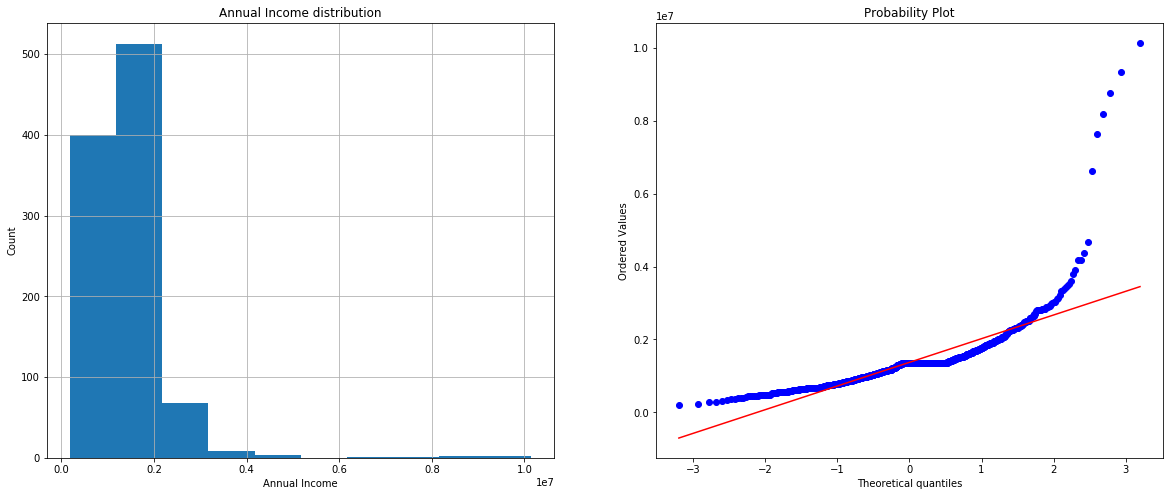

In [48]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Annual Income')
ax1.set_ylabel('Count')
ax1.set_title('Annual Income distribution')
features_s['Annual Income'].hist()

plt.subplot(122)
probplot(features_s['Annual Income'], dist='norm', plot=plt)

plt.show()

Визуальная оценка подтверждает показания критерия Шапиро-Уилка по поводу того, что закон распределения отличный от "нормального", в связи с чем, мы не сможем воспользоваться критерием Стьюдента для проверки гипотезы о равности мат. ожиданий признака Annual Income в группах с целевой переменной погашен вовремя и просрочка в следующем месяце, но мы сможем воспользоваться его непараметрическим аналогом - критерием Манна-Уитни, который не требователен к закону распределения.

*Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни*

H0: Средние равны  
H1: Средние не равны

In [49]:
statistic,pvalue=mannwhitneyu(features_target_0['Annual Income'], features_target_1['Annual Income'])
pvalue

0.07856264511659238

In [50]:
pvalue < alpha

False

Согласно значению p-value, гипотеза о равности мат. ожиданий хоть и не отвергается, но стоит ради дополнительной проверки обратиться к доверительным интервалам.

*Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их*

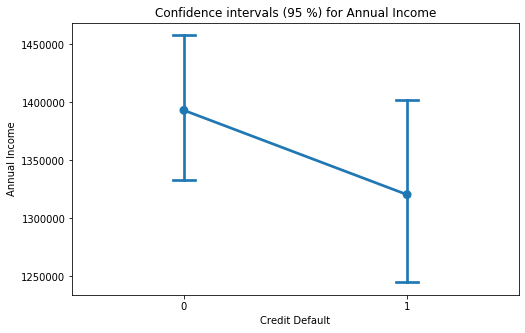

In [51]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Annual Income', data=features_with_target_s['Annual Income'], capsize=.1)

plt.title('Confidence intervals (95 %) for Annual Income')
plt.show()

По данному графику так же видно, что интервалы, в которых с 95% вероятностью должны находится истинные мат. ожидания этих двух групп,почти не пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Это означает, что группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), имеют различные распределения и признак 'Annual Income' может быть полезен для определения значения целевой переменной.

**Оценка признака "Number of Open Accounts" в разрезе целевой переменной**

*Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка признака 'Number of Open Accounts'*

$H0: Number of Open Accounts \sim N(\mu, \sigma^2)$  
$H1: H0  не  верна$

In [52]:
stat, p_value = shapiro(features_s['Number of Open Accounts'])
p_value

1.4847314002873825e-18

In [53]:
alpha=0.05
p_value < alpha

True

По полученному значению p-value, которое сильно меньше 0.05, можем заключить, что гипотеза о "нормальности" отвергается.

*Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график*

In [54]:
real_q_1 = np.quantile(features_s['Number of Open Accounts'], q=0.01)


mean = np.mean(features_s['Number of Open Accounts'])
std = np.std(features_s['Number of Open Accounts'])

normal_distr = mean + std * np.random.randn(10000)
theor_q_1 = np.quantile(normal_distr, q=0.01)

real_q_1, theor_q_1

(3.0, 0.1714406120840648)

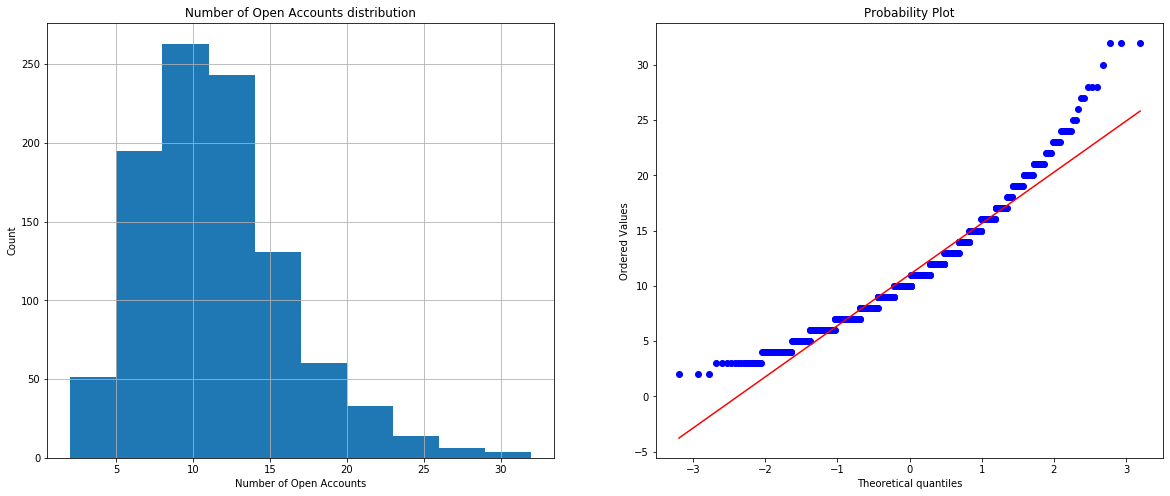

In [55]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Number of Open Accounts')
ax1.set_ylabel('Count')
ax1.set_title('Number of Open Accounts distribution')
features_s['Number of Open Accounts'].hist()

plt.subplot(122)
probplot(features_s['Number of Open Accounts'], dist='norm', plot=plt)

plt.show()

Визуальная оценка подтверждает показания критерия Шапиро-Уилка по поводу того, что закон распределения отличный от "нормального", в связи с чем, мы не сможем воспользоваться критерием Стьюдента для проверки гипотезы о равности мат. ожиданий признака Number of Open Accounts в группах с просроченным и непросроченным платежом в следующем месяце, но мы сможем воспользоваться его непараметрическим аналогом - критерием Манна-Уитни, который не требователен к закону распределения.

*Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни*

H0: Средние равны  
H1: Средние не равны

In [56]:
statistic,pvalue=mannwhitneyu(features_target_0['Number of Open Accounts'], features_target_1['Number of Open Accounts'])
pvalue

0.12787045880497827

In [57]:
pvalue < alpha

False

Согласно значению p-value, гипотеза о равности мат. ожиданий не отвергается, но стоит ради дополнительной проверки обратиться к доверительным интервалам.

*Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их*

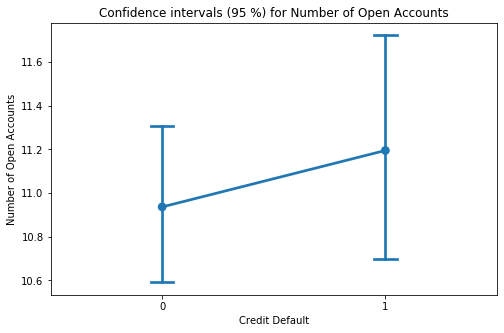

In [58]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Number of Open Accounts', data=features_with_target_s['Number of Open Accounts'], capsize=.1)

plt.title('Confidence intervals (95 %) for Number of Open Accounts')
plt.show()

По данному графику так же видно, что интервалы, в которых с 95% вероятностью должны находится истинные мат. ожидания этих двух групп, пересекаются,  что согласуется с результатами полученные с помощью критерия Манна-Уитни. 

Это означает, что группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), имеют очень близкое распределения и признак 'Number of Open Accounts' вряд ли будет полезен для определения значения целевой переменной.

**Оценка признака "Years of Credit History" в разрезе целевой переменной**

*Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка признака 'Years of Credit History'*

$H0: Years of Credit History \sim N(\mu, \sigma^2)$  
$H1: H0  не  верна$

In [59]:
stat, p_value = shapiro(features_s['Years of Credit History'])
p_value

3.702476577658691e-21

In [60]:
alpha=0.05
p_value < alpha

True

По полученному значению p-value, которое сильно меньше 0.05, можем заключить, что гипотеза о "нормальности" отвергается.

*Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график*

In [61]:
real_q_1 = np.quantile(features_s['Years of Credit History'], q=0.01)


mean = np.mean(features_s['Years of Credit History'])
std = np.std(features_s['Years of Credit History'])

normal_distr = mean + std * np.random.randn(10000)
theor_q_1 = np.quantile(normal_distr, q=0.01)

real_q_1, theor_q_1

(6.499, 1.7429501263033877)

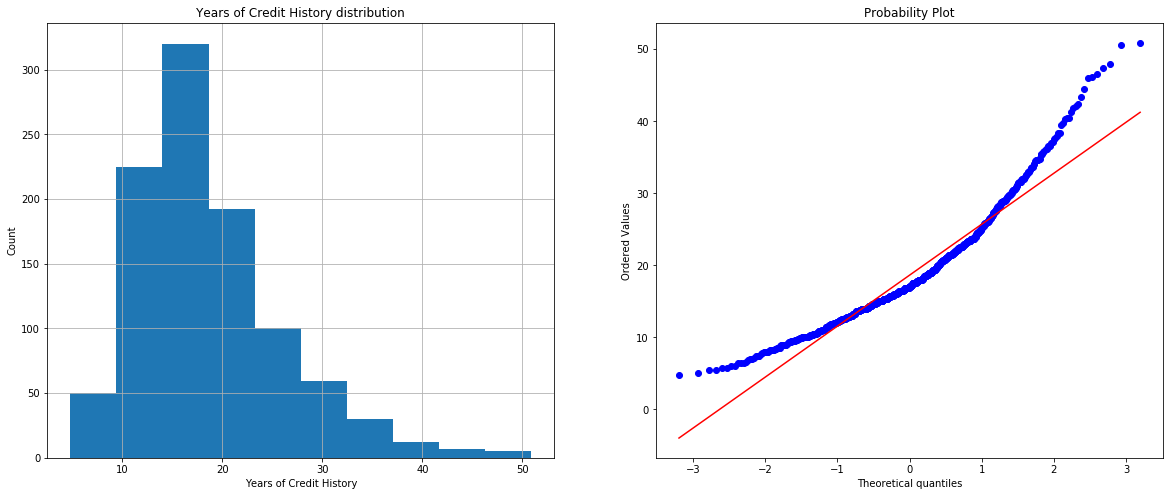

In [62]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Years of Credit History')
ax1.set_ylabel('Count')
ax1.set_title('Years of Credit History distribution')
features_s['Years of Credit History'].hist()

plt.subplot(122)
probplot(features_s['Years of Credit History'], dist='norm', plot=plt)

plt.show()

Визуальная оценка подтверждает показания критерия Шапиро-Уилка по поводу того, что закон распределения отличный от "нормального", в связи с чем, мы не сможем воспользоваться критерием Стьюдента для проверки гипотезы о равности мат. ожиданий признака Years of Credit History в группах с просроченным и непросроченным платежом в следующем месяце, но мы сможем воспользоваться его непараметрическим аналогом - критерием Манна-Уитни, который не требователен к закону распределения.

*Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни*

H0: Средние равны  
H1: Средние не равны

In [63]:
statistic,pvalue=mannwhitneyu(features_target_0['Years of Credit History'], features_target_1['Years of Credit History'])
pvalue

0.20618414308376343

In [64]:
pvalue < alpha

False

Согласно значению p-value, гипотеза о равности мат. ожиданий не отвергается, но стоит ради дополнительной проверки обратиться к доверительным интервалам.

*Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их*

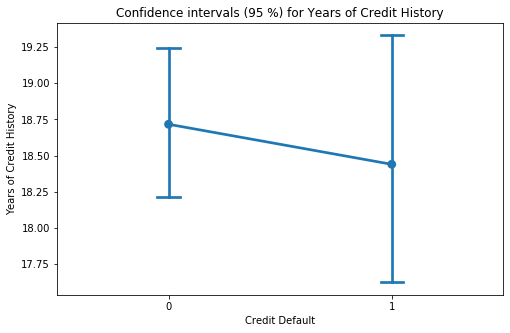

In [65]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Years of Credit History', data=features_with_target_s['Years of Credit History'], capsize=.1)

plt.title('Confidence intervals (95 %) for Years of Credit History')
plt.show()

По данному графику так же видно, что интервалы, в которых с 95% вероятностью должны находится истинные мат. ожидания этих двух групп, пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Это означает, что группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), имеют немного разное  распределения и признак 'Years of Credit History' все же может быть полезен для определения значения целевой переменной.

**Оценка признака "Current Credit Balance" в разрезе целевой переменной**


*Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка признака 'Current Credit Balance'*

$H0: Current Credit Balance \sim N(\mu, \sigma^2)$  
$H1: H0  не  верна$

In [66]:
stat, p_value = shapiro(features_s['Current Credit Balance'])
p_value


5.89946653480748e-43

In [67]:
alpha=0.05
p_value < alpha

True

По полученному значению p-value, которое сильно меньше 0.05, можем заключить, что гипотеза о "нормальности" отвергается.

*Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график*

In [68]:
real_q_1 = np.quantile(features_s['Current Credit Balance'], q=0.01)


mean = np.mean(features_s['Current Credit Balance'])
std = np.std(features_s['Current Credit Balance'])

normal_distr = mean + std * np.random.randn(10000)
theor_q_1 = np.quantile(normal_distr, q=0.01)

real_q_1, theor_q_1

(357.5800000000001, -497766.84452914563)

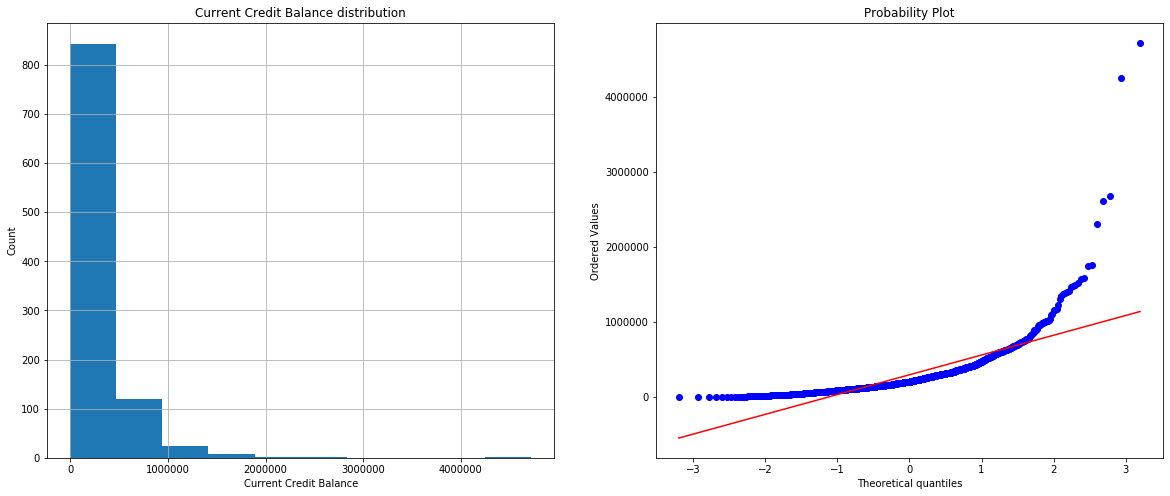

In [69]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Current Credit Balance')
ax1.set_ylabel('Count')
ax1.set_title('Current Credit Balance distribution')
features_s['Current Credit Balance'].hist()

plt.subplot(122)
probplot(features_s['Current Credit Balance'], dist='norm', plot=plt)

plt.show()

Визуальная оценка подтверждает показания критерия Шапиро-Уилка по поводу того, что закон распределения отличный от "нормального", в связи с чем, мы не сможем воспользоваться критерием Стьюдента для проверки гипотезы о равности мат. ожиданий признака Current Credit Balance в группах с просроченным и непросроченным платежом в следующем месяце, но мы сможем воспользоваться его непараметрическим аналогом - критерием Манна-Уитни, который не требователен к закону распределения.

*Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни*

H0: Средние равны  
H1: Средние не равны

In [70]:
statistic,pvalue=mannwhitneyu(features_target_0['Current Credit Balance'], features_target_1['Current Credit Balance'])
pvalue

0.3332450797418691

In [71]:
pvalue < alpha

False

Согласно значению p-value, гипотеза о равности мат. ожиданий хоть и не отвергается, но стоит ради дополнительной проверки обратиться к доверительным интервалам.

*Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их*

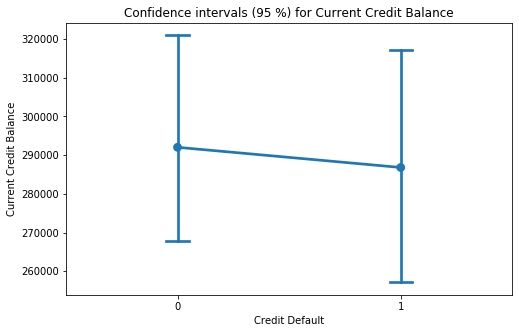

In [72]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Current Credit Balance', data=features_with_target_s['Current Credit Balance'], capsize=.1)

plt.title('Confidence intervals (95 %) for Current Credit Balance')
plt.show()

По данному графику так же видно, что интервалы, в которых с 95% вероятностью должны находится истинные мат. ожидания этих двух групп, пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Это означает, что группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), имеют сходное распределения и признак 'Current Credit Balance' может быть полезен для определения значения целевой переменной.

**Оценка признака "Monthly Debt" в разрезе целевой переменной**

*Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка признака 'Monthly Debt'*

$H0: Monthly Debt \sim N(\mu, \sigma^2)$  
$H1: H0  не  верна$

In [73]:
stat, p_value = shapiro(features_s['Monthly Debt'])
p_value


9.284154228208532e-22

In [74]:
alpha=0.05
p_value < alpha

True

По полученному значению p-value, которое сильно меньше 0.05, можем заключить, что гипотеза о "нормальности" отвергается.

*Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график*

In [75]:
real_q_1 = np.quantile(features_s['Monthly Debt'], q=0.01)


mean = np.mean(features_s['Monthly Debt'])
std = np.std(features_s['Monthly Debt'])

normal_distr = mean + std * np.random.randn(10000)
theor_q_1 = np.quantile(normal_distr, q=0.01)

real_q_1, theor_q_1

(1312.5300000000002, -7073.363484083272)

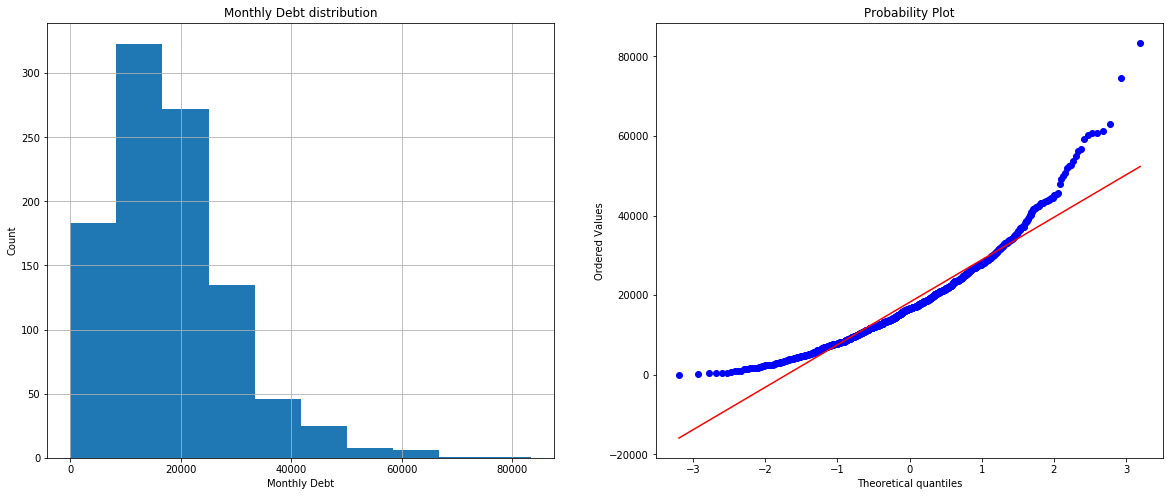

In [76]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Monthly Debt')
ax1.set_ylabel('Count')
ax1.set_title('Monthly Debt distribution')
features_s['Monthly Debt'].hist()

plt.subplot(122)
probplot(features_s['Monthly Debt'], dist='norm', plot=plt)

plt.show()

Визуальная оценка подтверждает показания критерия Шапиро-Уилка по поводу того, что закон распределения отличный от "нормального", в связи с чем, мы не сможем воспользоваться критерием Стьюдента для проверки гипотезы о равности мат. ожиданий признака Monthly Debt в группах с просроченным и непросроченным платежом в следующем месяце, но мы сможем воспользоваться его непараметрическим аналогом - критерием Манна-Уитни, который не требователен к закону распределения.

*Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни*

H0: Средние равны  
H1: Средние не равны

In [77]:
statistic,pvalue=mannwhitneyu(features_target_0['Monthly Debt'], features_target_1['Monthly Debt'])
pvalue

0.3121441949766719

In [78]:
pvalue < alpha

False

Согласно значению p-value, гипотеза о равности мат. ожиданий не отвергается, но стоит ради дополнительной проверки обратиться к доверительным интервалам. 

*Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их*

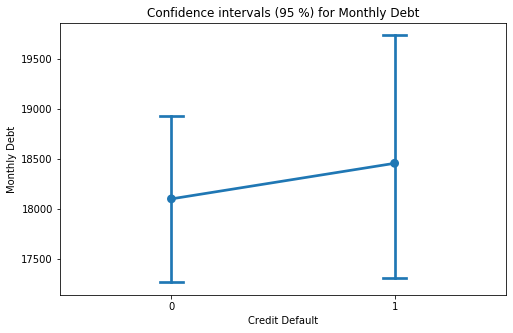

In [79]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Monthly Debt', data=features_with_target_s['Monthly Debt'], capsize=.1)

plt.title('Confidence intervals (95 %) for Monthly Debt')
plt.show()

По данному графику так же видно, что интервалы, в которых с 95% вероятностью должны находится истинные мат. ожидания этих двух групп, пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни. 

Это означает, что группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), имеют немного разное распределения и признак 'Monthly Debt'  может быть полезен для определения значения целевой переменной.

**Оценка признака "Maximum Open Credit" в разрезе целевой переменной**

*Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка признака 'Maximum Open Credit'*

$H0: Maximum Open Credit \sim N(\mu, \sigma^2)$  
$H1: H0  не  верна$

In [80]:
stat, p_value = shapiro(features_s['Maximum Open Credit'])
p_value

2.802596928649634e-45

In [81]:
alpha=0.05
p_value < alpha

True

По полученному значению p-value, которое сильно меньше 0.05, можем заключить, что гипотеза о "нормальности" отвергается.

*Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график*

In [82]:
real_q_1 = np.quantile(features_s['Maximum Open Credit'], q=0.01)


mean = np.mean(features_s['Maximum Open Credit'])
std = np.std(features_s['Maximum Open Credit'])

normal_distr = mean + std * np.random.randn(10000)
theor_q_1 = np.quantile(normal_distr, q=0.01)

real_q_1, theor_q_1

(10846.440000000002, -1119175.4976143418)

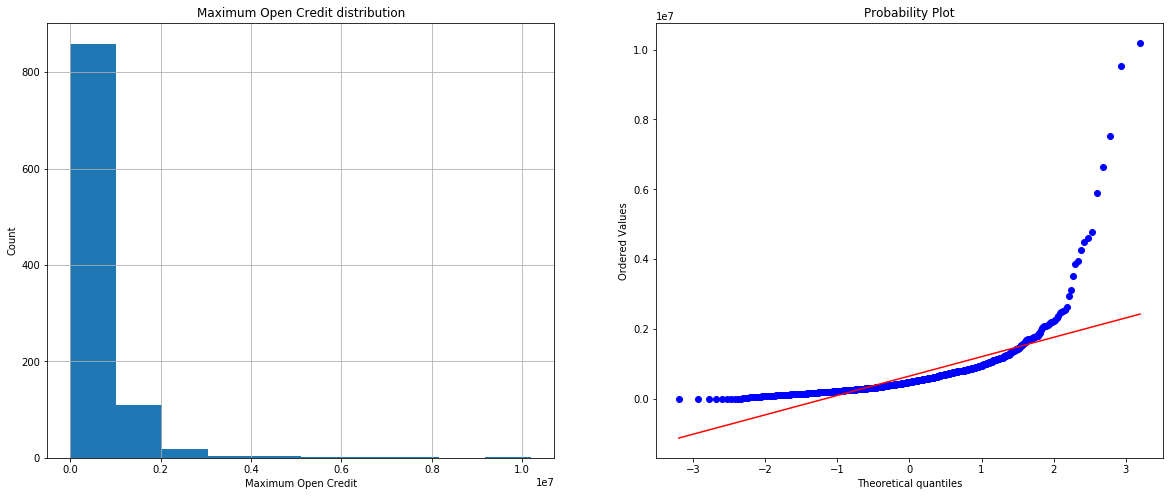

In [83]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Maximum Open Credit')
ax1.set_ylabel('Count')
ax1.set_title('Maximum Open Credit distribution')
features_s['Maximum Open Credit'].hist()

plt.subplot(122)
probplot(features_s['Maximum Open Credit'], dist='norm', plot=plt)

plt.show()

Визуальная оценка подтверждает показания критерия Шапиро-Уилка по поводу того, что закон распределения отличный от "нормального", в связи с чем, мы не сможем воспользоваться критерием Стьюдента для проверки гипотезы о равности мат. ожиданий признака Maximum Open Credit в группах с просроченным и непросроченным платежом в следующем месяце, но мы сможем воспользоваться его непараметрическим аналогом - критерием Манна-Уитни, который не требователен к закону распределения.

*Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни*

H0: Средние равны  
H1: Средние не равны

In [84]:
statistic,pvalue=mannwhitneyu(features_target_0['Maximum Open Credit'], features_target_1['Maximum Open Credit'])
pvalue

0.005101673945978122

In [85]:
alpha=0.05
pvalue < alpha

True

Согласно значению p-value, гипотеза о равности мат. ожиданий отвергается, но стоит ради дополнительной проверки обратиться к доверительным интервалам.

*Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их*

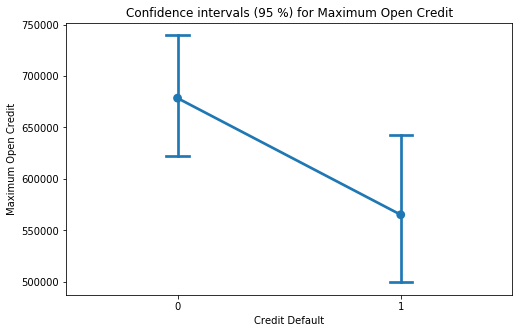

In [86]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Maximum Open Credit', data=features_with_target_s['Maximum Open Credit'], capsize=.1)

plt.title('Confidence intervals (95 %) for Maximum Open Credit')
plt.show()

По данному графику так же видно, что интервалы, в которых с 95% вероятностью должны находится истинные мат. ожидания этих двух групп, не пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Это означает, что группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), имеют различные распределения и этот признак Maximum Open Credit может быть полезен для определения значения целевой переменной.

**Исследуем другие некотегариальные признаки  только с помощью критерия Манна-Уитни и доверительных интервалов, т.к. они явно распределены не "нормально".**


**Оценка признака "Tax Liens" в разрезе целевой переменной**

*Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка признака 'Tax Liens'*

$H0: Tax Liens \sim N(\mu, \sigma^2)$  
$H1: H0  не  верна$

In [87]:
stat, p_value = shapiro(features_s['Tax Liens'])
p_value

0.0

In [88]:
alpha=0.05
p_value < alpha

True

По полученному значению p-value, которое сильно меньше 0.05, можем заключить, что гипотеза о "нормальности" отвергается.

*Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни*

H0: Средние равны  
H1: Средние не равны

In [89]:
statistic,pvalue=mannwhitneyu(features_target_0['Tax Liens'], features_target_1['Tax Liens'])
pvalue

0.22782246353833202

In [90]:
alpha=0.05
pvalue < alpha

False

Согласно значению p-value, гипотеза о равности мат. ожиданий не отвергается, но стоит ради дополнительной проверки обратиться к доверительным интервалам.

*Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их*

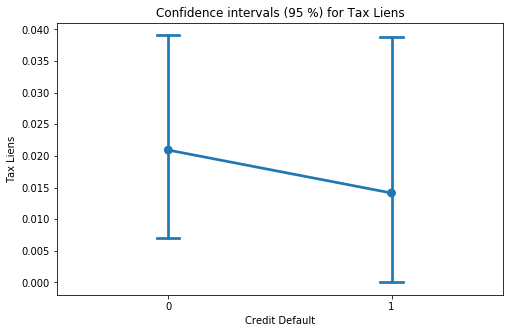

In [91]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Tax Liens', data=features_with_target_s['Tax Liens'], capsize=.1)

plt.title('Confidence intervals (95 %) for Tax Liens')
plt.show()

По данному графику так же видно, что интервалы, в которых с 95% вероятностью должны находится истинные мат. ожидания этих двух групп, почти не пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Это означает, что группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), имеют немного разные распределения и этот признак Tax Liens  может быть полезен для определения значения целевой переменной.

**Оценка признака "Number of Credit Problems" в разрезе целевой переменной**

*Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка признака 'Number of Credit Problems'*

$H0: Number of Credit Problems \sim N(\mu, \sigma^2)$  
$H1: H0  не  верна$

In [92]:
stat, p_value = shapiro(features_s['Number of Credit Problems'])
p_value

0.0

In [93]:
alpha=0.05
p_value < alpha

True

По полученному значению p-value, которое сильно меньше 0.05, можем заключить, что гипотеза о "нормальности" отвергается.

*Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни*

H0: Средние равны  
H1: Средние не равны

In [94]:
statistic,pvalue=mannwhitneyu(features_target_0['Number of Credit Problems'], features_target_1['Number of Credit Problems'])
pvalue

0.2687515575442473

In [95]:
alpha=0.05
pvalue < alpha

False

Согласно значению p-value, гипотеза о равности мат. ожиданий не отвергается, но стоит ради дополнительной проверки обратиться к доверительным интервалам.

*Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их*

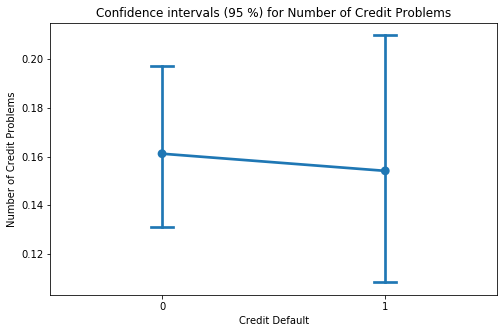

In [96]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Number of Credit Problems', data=features_with_target_s['Number of Credit Problems'], capsize=.1)

plt.title('Confidence intervals (95 %) for Number of Credit Problems')
plt.show()

По данному графику так же видно, что интервалы, в которых с 95% вероятностью должны находится истинные мат. ожидания этих двух групп,  пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Это означает, что группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), хотя и имеют во многом общее распределения, тем не менее есть и разные участки и этот признак Number of Credit Problems может быть полезен для определения значения целевой переменной.

**Оценка признака "Months since last delinquent" в разрезе целевой переменной**

*Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка признака 'Months since last delinquent'*

$H0: Months since last delinquent \sim N(\mu, \sigma^2)$  
$H1: H0  не  верна$

In [97]:
stat, p_value = shapiro(features_s['Months since last delinquent'])
p_value

1.3519864815883631e-31

In [98]:
alpha=0.05
p_value < alpha

True

По полученному значению p-value, которое сильно меньше 0.05, можем заключить, что гипотеза о "нормальности" отвергается.

*Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни*

H0: Средние равны  
H1: Средние не равны

In [99]:
statistic,pvalue=mannwhitneyu(features_target_0['Months since last delinquent'], features_target_1['Months since last delinquent'])
pvalue

0.2054643994652502

In [100]:
alpha=0.05
pvalue < alpha

False

Согласно значению p-value, гипотеза о равности мат. не ожиданий   отвергается, но стоит ради дополнительной проверки обратиться к доверительным интервалам.

*Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их*

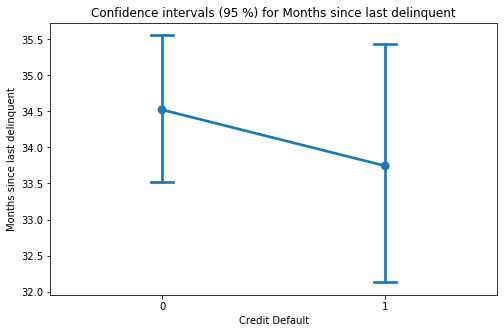

In [101]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Months since last delinquent', data=features_with_target_s['Months since last delinquent'], capsize=.1)

plt.title('Confidence intervals (95 %) for Months since last delinquent')
plt.show()

По данному графику так же видно, что интервалы, в которых с 95% вероятностью должны находится истинные мат. ожидания этих двух групп, не сильно пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Это означает, что группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), имеют немного разные распределения и этот признак Months since last delinquent может быть полезен для определения значения целевой переменной.

**Оценка признака "Bankruptcies" в разрезе целевой переменной**

*Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка признака 'Bankruptcies'*

$H0: Bankruptcies \sim N(\mu, \sigma^2)$  
$H1: H0  не  верна$

In [102]:
stat, p_value = shapiro(features_s['Bankruptcies'])
p_value

0.0

In [103]:
alpha=0.05
p_value < alpha

True

По полученному значению p-value, которое сильно меньше 0.05, можем заключить, что гипотеза о "нормальности" отвергается.

*Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни*

H0: Средние равны  
H1: Средние не равны

In [104]:
statistic,pvalue=mannwhitneyu(features_target_0['Bankruptcies'], features_target_1['Bankruptcies'])
pvalue

0.04458997789918873

In [105]:
alpha=0.05
pvalue < alpha

True

Согласно значению p-value, гипотеза о равности мат. ожиданий отвергается, но стоит ради дополнительной проверки обратиться к доверительным интервалам.

*Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их*

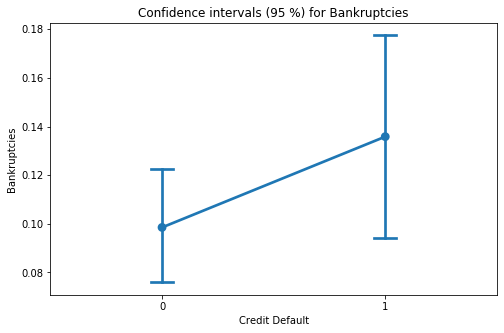

In [106]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Bankruptcies', data=features_with_target_s['Bankruptcies'], capsize=.1)

plt.title('Confidence intervals (95 %) for Bankruptcies')
plt.show()

По данному графику так же видно, что интервалы, в которых с 95% вероятностью должны находится истинные мат. ожидания этих двух групп, сильно пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Это означает, что группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), имеют немного различные распределения и этот признак Bankruptcies  может быть полезен для определения значения целевой переменной.

**Оценка признака "Current Loan Amount" в разрезе целевой переменной**

*Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка признака 'Current Loan Amount'*

$H0: Current Loan Amount \sim N(\mu, \sigma^2)$  
$H1: H0  не  верна$

In [107]:
stat, p_value = shapiro(features_s['Current Loan Amount'])
p_value

0.0

In [108]:
alpha=0.05
p_value < alpha

True

По полученному значению p-value, которое сильно меньше 0.05, можем заключить, что гипотеза о "нормальности" отвергается.

*Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни*

H0: Средние равны  
H1: Средние не равны

In [109]:
statistic,pvalue=mannwhitneyu(features_target_0['Current Loan Amount'], features_target_1['Current Loan Amount'])
pvalue

0.03260884758930729

In [110]:
alpha=0.05
pvalue < alpha

True

Согласно значению p-value, гипотеза о равности мат. ожиданий отвергается, но стоит ради дополнительной проверки обратиться к доверительным интервалам.

*Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их*

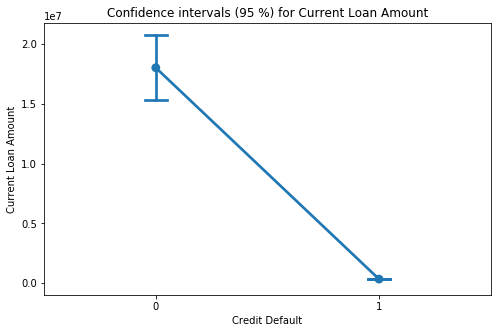

In [111]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Current Loan Amount', data=features_with_target_s['Current Loan Amount'], capsize=.1)

plt.title('Confidence intervals (95 %) for Current Loan Amount')
plt.show()

По данному графику так же видно, что интервалы, в которых с 95% вероятностью должны находится истинные мат. ожидания этих двух групп, не пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Это означает, что группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), имеют различные распределения и этот признак Current Loan Amount может быть полезен для определения значения целевой переменной.

**Оценка признака "Credit Score" в разрезе целевой переменной**

*Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка признака 'Credit Score'*

$H0: Credit Score \sim N(\mu, \sigma^2)$  
$H1: H0  не  верна$

In [112]:
stat, p_value = shapiro(features_s['Credit Score'])
p_value

0.0

In [113]:
alpha=0.05
p_value < alpha

True

По полученному значению p-value, которое сильно меньше 0.05, можем заключить, что гипотеза о "нормальности" отвергается.

*Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни*

H0: Средние равны  
H1: Средние не равны

In [114]:
statistic,pvalue=mannwhitneyu(features_target_0['Credit Score'], features_target_1['Credit Score'])
pvalue

1.0361634470347294e-05

In [115]:
alpha=0.05
pvalue < alpha

True

Согласно значению p-value, гипотеза о равности мат. ожиданий  отвергается, но стоит ради дополнительной проверки обратиться к доверительным интервалам.

*Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их*

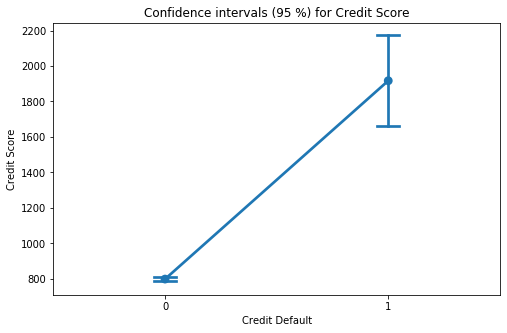

In [116]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Credit Score', data=features_with_target_s['Credit Score'], capsize=.1)

plt.title('Confidence intervals (95 %) for Credit Score')
plt.show()

По данному графику так же видно, что интервалы, в которых с 95% вероятностью должны находится истинные мат. ожидания этих двух групп, не пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Это означает, что группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), имеют различные распределения и этот признак Credit Score может быть полезен для определения значения целевой переменной.

**Удаляем неинформативные признаки**

In [117]:
NOT_INFORMATION_FEATURES=['Number of Open Accounts']

In [118]:
df_prep_train.drop(columns=NOT_INFORMATION_FEATURES,axis=1,inplace=True)

df_prep_train.columns.tolist()

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default',
 'ID',
 'Home Ownership_Have Mortgage',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Years in current job_10+ years',
 'Years in current job_2 years',
 'Years in current job_3 years',
 'Years in current job_4 years',
 'Years in current job_6 years',
 'Years in current job_7 years',
 'Years in current job_8 years',
 'Years in current job_9 years',
 'Years in current job_less_1_and_1_and_5_year',
 'Purpose_debt consolidation',
 'Purpose_other and home improvements',
 'Purpose_small purposes',
 'Term_Long Term',
 'Term_Short Term']

In [119]:
NUMERIC_FEATURE_NAMES = ['Months since last delinquent','Tax Liens','Maximum Open Credit','Bankruptcies','Current Credit Balance','Annual Income','Years of Credit History','Number of Credit Problems', 'Current Loan Amount', 'Monthly Debt','Credit Score']

FEATURE_NAMES_SELECTED = NUMERIC_FEATURE_NAMES + NEW_FEATURE_NAMES
FEATURE_NAMES_SELECTED

['Months since last delinquent',
 'Tax Liens',
 'Maximum Open Credit',
 'Bankruptcies',
 'Current Credit Balance',
 'Annual Income',
 'Years of Credit History',
 'Number of Credit Problems',
 'Current Loan Amount',
 'Monthly Debt',
 'Credit Score',
 'Home Ownership_Have Mortgage',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Years in current job_10+ years',
 'Years in current job_2 years',
 'Years in current job_3 years',
 'Years in current job_4 years',
 'Years in current job_6 years',
 'Years in current job_7 years',
 'Years in current job_8 years',
 'Years in current job_9 years',
 'Years in current job_less_1_and_1_and_5_year',
 'Purpose_debt consolidation',
 'Purpose_other and home improvements',
 'Purpose_small purposes',
 'Term_Long Term',
 'Term_Short Term']

In [120]:
categorial_columns=['Home Ownership','Years in current job','Purpose','Term']
df_prep_train.drop(columns=categorial_columns,axis=1,inplace=True)

### 7. Балансировка классов<a class="anchor" id="new_features"></a>

In [121]:
import pandas as pd
import numpy as np
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [122]:
import warnings
warnings.simplefilter('ignore')

In [123]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    
    print('CONFUSION MATRIX TEST\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [124]:
def balance_df_by_target(df, target_name='Credit Default'):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) # случайгое перемешивание данных

In [125]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))
    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [126]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [127]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

### Нормализация данных<a class="anchor" id="normalization"></a>

In [128]:
scaler = StandardScaler()

df_norm = df_prep_train.copy()
df_norm[NUMERIC_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUMERIC_FEATURE_NAMES])

df_prep_train = df_norm.copy()

### Разбиение на train и test<a class="anchor" id="train_and_test"></a>

(!) ДО балансировки классов

In [129]:
X = df_prep_train[FEATURE_NAMES_SELECTED]
y = df_prep_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=211)

### Балансировка целевой переменной<a class="anchor" id="target_balancing"></a>

(!) Балансируем только на train  
(!) Качество оцениваем на тесте БЕЗ балансировки

Не обязательно балансировать в пропорции 50-50. На самом деле, это тоже гиперпараметр

In [130]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    4047
1    3156
Name: Credit Default, dtype: int64

In [131]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Построение и оценка базовых моделей<a class="anchor" id="baseline_modeling"></a> 

**Логистическая регрессия**

In [132]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.68      0.84      0.75      4047
           1       0.71      0.50      0.59      3156

    accuracy                           0.69      7203
   macro avg       0.69      0.67      0.67      7203
weighted avg       0.69      0.69      0.68      7203

TEST

              precision    recall  f1-score   support

           0       0.82      0.85      0.83      1340
           1       0.58      0.53      0.55       535

    accuracy                           0.76      1875
   macro avg       0.70      0.69      0.69      1875
weighted avg       0.75      0.76      0.75      1875

CONFUSION MATRIX TEST

col_0              0    1
Credit Default           
0               1135  205
1                252  283


**k ближайших соседей**

In [133]:
model_knn = KNeighborsClassifier(n_neighbors=15)
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.79      0.76      4047
           1       0.70      0.64      0.67      3156

    accuracy                           0.72      7203
   macro avg       0.72      0.72      0.72      7203
weighted avg       0.72      0.72      0.72      7203

TEST

              precision    recall  f1-score   support

           0       0.80      0.76      0.78      1340
           1       0.46      0.51      0.49       535

    accuracy                           0.69      1875
   macro avg       0.63      0.64      0.63      1875
weighted avg       0.70      0.69      0.70      1875

CONFUSION MATRIX TEST

col_0              0    1
Credit Default           
0               1021  319
1                260  275


**Бустинговые алгоритмы**

*XGBoost*

In [134]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4047
           1       0.97      0.94      0.96      3156

    accuracy                           0.96      7203
   macro avg       0.96      0.96      0.96      7203
weighted avg       0.96      0.96      0.96      7203

TEST

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1340
           1       0.54      0.49      0.51       535

    accuracy                           0.74      1875
   macro avg       0.67      0.66      0.67      1875
weighted avg       0.73      0.74      0.73      1875

CONFUSION MATRIX TEST

col_0              0    1
Credit Default           
0               1121  219
1                275  260


*LightGBM*

In [135]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.95      0.92      4047
           1       0.93      0.86      0.90      3156

    accuracy                           0.91      7203
   macro avg       0.92      0.91      0.91      7203
weighted avg       0.91      0.91      0.91      7203

TEST

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1340
           1       0.53      0.47      0.50       535

    accuracy                           0.73      1875
   macro avg       0.66      0.65      0.66      1875
weighted avg       0.72      0.73      0.72      1875

CONFUSION MATRIX TEST

col_0              0    1
Credit Default           
0               1119  221
1                285  250


*CatBoost*

In [136]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      4047
           1       0.93      0.84      0.88      3156

    accuracy                           0.90      7203
   macro avg       0.91      0.89      0.90      7203
weighted avg       0.90      0.90      0.90      7203

TEST

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1340
           1       0.57      0.49      0.53       535

    accuracy                           0.75      1875
   macro avg       0.69      0.67      0.68      1875
weighted avg       0.74      0.75      0.74      1875

CONFUSION MATRIX TEST

col_0              0    1
Credit Default           
0               1147  193
1                274  261


### Выбор лучшей модели и подбор гиперпараметров<a class="anchor" id="tuning_best_model"></a> 

**Лучшая модель для нашей задачи - Логистическая регрессия**

**Подбор гиперпараметров**

In [167]:
model_lr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'warn',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [138]:
#params = {'penalty':['l1', 'l2', 'elasticnet'], 
#          'class_weight':['balanced',None],
#          'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga','warn']}

params = {'penalty':['l2'], 
          'class_weight':['balanced',None],
          'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga','warn']}

In [139]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [140]:
%%time

rs = GridSearchCV(model_lr, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)

Wall time: 2.75 s


GridSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'class_weight': ['balanced', None], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga', 'warn']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=Fals

In [141]:
rs.best_params_

{'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}

In [142]:
rs.best_score_

0.628046468650342

**Обучение и оценка финальной модели**

In [143]:
%%time

final_model = LogisticRegression(class_weight='balanced', penalty= 'l2',solver='newton-cg')

final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.71      0.70      0.71      4047
           1       0.62      0.64      0.63      3156

    accuracy                           0.67      7203
   macro avg       0.67      0.67      0.67      7203
weighted avg       0.67      0.67      0.67      7203

TEST

              precision    recall  f1-score   support

           0       0.84      0.70      0.77      1340
           1       0.48      0.67      0.56       535

    accuracy                           0.69      1875
   macro avg       0.66      0.69      0.66      1875
weighted avg       0.74      0.69      0.71      1875

CONFUSION MATRIX TEST

col_0             0    1
Credit Default          
0               944  396
1               176  359
Wall time: 95 ms


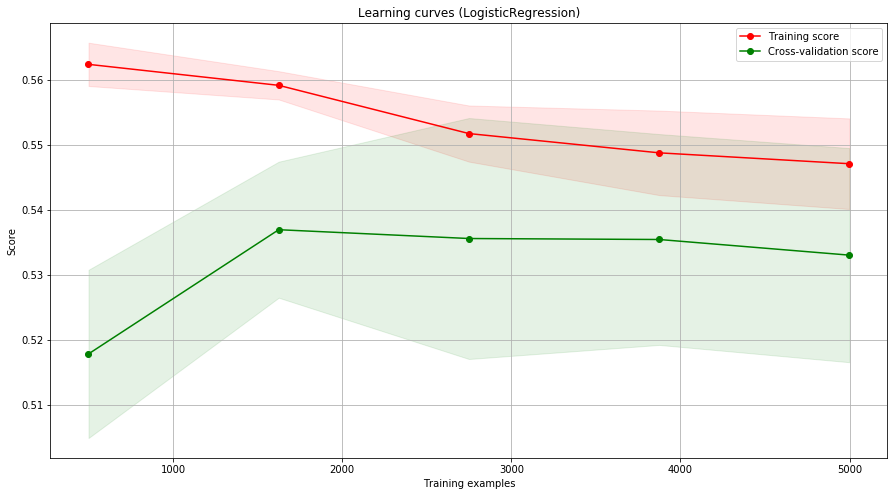

In [144]:
#кривая обучения
show_learning_curve_plot(final_model, X, y)

Модель вышла на плато гто на количество данных=1800

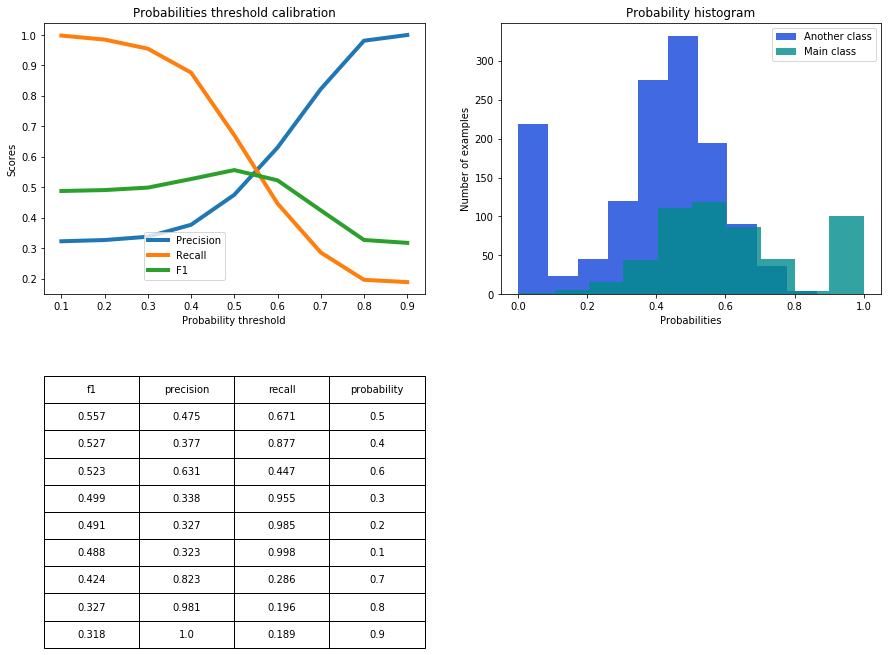

In [145]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

### Прогноз по целевому датасету<a class="anchor" id="saving_model"></a> 

Подготовка данных целевого датасета - очистка, удаление пропусков, выбросов, порождение новых dummy полей, нормализация и т.д.

In [146]:
len(df_test) - df_test.count()

Home Ownership                     0
Annual Income                    513
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

In [147]:
for cat_colname in df_test.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_test[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    810
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
nan           86
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
vacation                   3
educational expenses       3
wedding                    2
movi

In [148]:
df_test.loc[df_test['Annual Income'].isnull() , 'Annual Income'] = df_test['Annual Income'].mean()
df_test.loc[df_test['Months since last delinquent'].isnull() , 'Months since last delinquent'] = df_test['Months since last delinquent'].mean()
df_test.loc[df_test['Bankruptcies'].isnull() , 'Bankruptcies'] = df_test['Bankruptcies'].mean()
df_test.loc[df_test['Credit Score'].isnull() , 'Credit Score'] = df_test['Credit Score'].mean()

In [149]:
df_test.loc[df_test['Years in current job']=='nan' , 'Years in current job'] = df_test['Years in current job'].mode()[0]

In [150]:
for colname in ['Home Ownership', 'Years in current job', 'Purpose', 'Term']:
    df_test[colname] = df_test[colname].astype(str)

In [151]:
df_test.loc[df_test['Years in current job'].isin(['< 1 year', '1 year','5 years']),['Years in current job']]='less_1_and_1_and_5_year'
df_test.loc[df_test['Purpose'].isin(['other', 'home improvements']),['Purpose']]='other and home improvements'
df_test.loc[df_test['Purpose'].isin(['business loan', 'buy a car', 'medical bills', 'major purchase', 'take a trip', 'buy house', 'small business', 'wedding', 'moving', 'educational expenses', 'vacation', 'renewable energy']), ['Purpose']]='small purposes'


In [152]:
df_test['ID'] = df_test.index.tolist()

In [153]:
df_prep_test=df_test
for cat_colname in df_prep_test.select_dtypes(include='object').columns[0:]:
    df_prep_test = pd.concat([df_prep_test, pd.get_dummies(df_prep_test[cat_colname], prefix=cat_colname)], axis=1)

In [154]:
df_prep_test.drop(columns=NOT_INFORMATION_FEATURES,axis=1,inplace=True)
df_prep_test.drop(columns=categorial_columns,axis=1,inplace=True)

In [155]:
df_prep_test.shape

(2500, 30)

In [156]:
df_norm = df_prep_test.copy()
df_norm[NUMERIC_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUMERIC_FEATURE_NAMES])
df_prep_test = df_norm.copy()

In [157]:
X_train.columns.tolist()

['Months since last delinquent',
 'Tax Liens',
 'Maximum Open Credit',
 'Bankruptcies',
 'Current Credit Balance',
 'Annual Income',
 'Years of Credit History',
 'Number of Credit Problems',
 'Current Loan Amount',
 'Monthly Debt',
 'Credit Score',
 'Home Ownership_Have Mortgage',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Years in current job_10+ years',
 'Years in current job_2 years',
 'Years in current job_3 years',
 'Years in current job_4 years',
 'Years in current job_6 years',
 'Years in current job_7 years',
 'Years in current job_8 years',
 'Years in current job_9 years',
 'Years in current job_less_1_and_1_and_5_year',
 'Purpose_debt consolidation',
 'Purpose_other and home improvements',
 'Purpose_small purposes',
 'Term_Long Term',
 'Term_Short Term']

In [158]:
df_prep_test.columns.tolist()

['Annual Income',
 'Tax Liens',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'ID',
 'Home Ownership_Have Mortgage',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Years in current job_10+ years',
 'Years in current job_2 years',
 'Years in current job_3 years',
 'Years in current job_4 years',
 'Years in current job_6 years',
 'Years in current job_7 years',
 'Years in current job_8 years',
 'Years in current job_9 years',
 'Years in current job_less_1_and_1_and_5_year',
 'Purpose_debt consolidation',
 'Purpose_other and home improvements',
 'Purpose_small purposes',
 'Term_Long Term',
 'Term_Short Term']

In [159]:
y_test_pred = final_model.predict(df_prep_test[FEATURE_NAMES_SELECTED])

### Сохранение модели<a class="anchor" id="saving_model"></a> 

In [160]:
SCALER_FILE_PATH = 'models/scaler.pkl'
MODEL_FILE_PATH = 'models/model.pkl'
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)
    
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

In [161]:
y_test_pred

array([1, 1, 1, ..., 0, 0, 1], dtype=int64)

In [162]:
len(df_test)

2500

In [163]:
len(y_test_pred)

2500

In [164]:
df_test['Credit Default']=y_test_pred

In [165]:
df_test['Credit Default']

0       1
1       1
2       1
3       1
4       0
       ..
2495    0
2496    0
2497    0
2498    0
2499    1
Name: Credit Default, Length: 2500, dtype: int64

In [166]:
df_test.to_csv('data/AUkladnikov_predictions.csv', index=True, encoding='utf-8')